In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Read Dataset

In [3]:
df = pd.read_csv('/home/skpark/git/pose-detection-keypoints-estimation-yolov8/class_train/class.csv')

#df = pd.read_csv('/content/drive/MyDrive/yoga_pose_keypoint3.csv')
df.head()

,image_name,label,nose_x,nose_y,upper_jaw_x,upper_jaw_y,lower_jaw_x,lower_jaw_y,mouth_end_right_x,mouth_end_right_y,...,back_right_paw_x,back_right_paw_y,back_right_knee_x,back_right_knee_y,belly_bottom_x,belly_bottom_y,body_middle_right_x,body_middle_right_y,body_middle_left_x,body_middle_left_y
0,718frame_114_timestamp_3800.jpg,lying,0.434045,0.270043,0.437416,0.298502,0.437731,0.317950,0.392618,0.329453,...,0.418793,0.867981,0.329831,0.800339,0.520640,0.731121,0.229709,0.637976,0.724300,0.634448
1,259frame_155_timestamp_5172.jpg,lying,0.473927,0.356986,0.469231,0.371849,0.463683,0.381182,0.448187,0.383461,...,0.540606,0.716510,0.521788,0.671610,0.545363,0.617157,0.381359,0.582433,0.579443,0.562518
2,288frame_102_timestamp_3400.jpg,lying,0.864117,0.371903,0.853304,0.389583,0.832232,0.403876,0.797892,0.397075,...,0.222524,0.841114,0.163332,0.645658,0.339027,0.646505,0.247608,0.563466,0.488524,0.560244
3,1117frame_11_timestamp_367.jpg,lying,0.708410,0.228683,0.704935,0.250225,0.696675,0.267725,0.643889,0.269487,...,0.332659,0.750346,0.288798,0.652259,0.411699,0.593063,0.268051,0.512297,0.648864,0.511372
4,60frame_155_timestamp_5172.jpg,lying,0.229645,0.263112,0.238608,0.299905,0.263886,0.333295,0.296489,0.324152,...,0.743284,0.905063,0.660405,0.769294,0.830326,0.793733,0.492758,0.622019,1.000000,0.641701


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image_name           826 non-null    object 
 1   label                826 non-null    object 
 2   nose_x               826 non-null    float64
 3   nose_y               826 non-null    float64
 4   upper_jaw_x          826 non-null    float64
 5   upper_jaw_y          826 non-null    float64
 6   lower_jaw_x          826 non-null    float64
 7   lower_jaw_y          826 non-null    float64
 8   mouth_end_right_x    826 non-null    float64
 9   mouth_end_right_y    826 non-null    float64
 10  mouth_end_left_x     826 non-null    float64
 11  mouth_end_left_y     826 non-null    float64
 12  right_eye_x          826 non-null    float64
 13  right_eye_y          826 non-null    float64
 14  right_earbase_x      826 non-null    float64
 15  right_earbase_y      826 non-null    flo

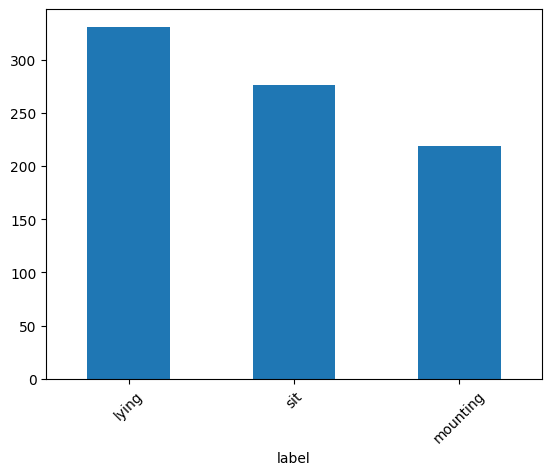

In [5]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

## Train Test Split

In [6]:
# encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([0.83182276, 1.25722983, 0.99758454])

In [8]:
# Get keypoint dataset
X = df.iloc[:,2:]
X

,nose_x,nose_y,upper_jaw_x,upper_jaw_y,lower_jaw_x,lower_jaw_y,mouth_end_right_x,mouth_end_right_y,mouth_end_left_x,mouth_end_left_y,...,back_right_paw_x,back_right_paw_y,back_right_knee_x,back_right_knee_y,belly_bottom_x,belly_bottom_y,body_middle_right_x,body_middle_right_y,body_middle_left_x,body_middle_left_y
0,0.434045,0.270043,0.437416,0.298502,0.437731,0.317950,0.392618,0.329453,0.493179,0.320371,...,0.418793,0.867981,0.329831,0.800339,0.520640,0.731121,0.229709,0.637976,0.724300,0.634448
1,0.473927,0.356986,0.469231,0.371849,0.463683,0.381182,0.448187,0.383461,0.479799,0.377387,...,0.540606,0.716510,0.521788,0.671610,0.545363,0.617157,0.381359,0.582433,0.579443,0.562518
2,0.864117,0.371903,0.853304,0.389583,0.832232,0.403876,0.797892,0.397075,0.803644,0.390467,...,0.222524,0.841114,0.163332,0.645658,0.339027,0.646505,0.247608,0.563466,0.488524,0.560244
3,0.708410,0.228683,0.704935,0.250225,0.696675,0.267725,0.643889,0.269487,0.703072,0.262972,...,0.332659,0.750346,0.288798,0.652259,0.411699,0.593063,0.268051,0.512297,0.648864,0.511372
4,0.229645,0.263112,0.238608,0.299905,0.263886,0.333295,0.296489,0.324152,0.361241,0.321706,...,0.743284,0.905063,0.660405,0.769294,0.830326,0.793733,0.492758,0.622019,1.000000,0.641701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.897745,0.554479,0.885727,0.567733,0.876101,0.580370,0.830056,0.568323,0.897490,0.560227,...,0.239945,0.807568,0.204961,0.708560,0.394908,0.709519,0.381008,0.610820,0.740198,0.614476
822,0.108225,0.340964,0.117141,0.356745,0.137136,0.371626,0.150474,0.358091,0.148786,0.360808,...,0.548341,0.756599,0.592841,0.601771,0.497772,0.615464,0.417767,0.517163,0.598614,0.531132
823,0.381254,0.761414,0.387788,0.772844,0.393072,0.777763,0.375997,0.741810,0.402293,0.739859,...,0.518507,0.758251,0.512278,0.696610,0.492203,0.701253,0.424222,0.536290,0.513829,0.553193
824,0.610283,0.808312,0.611037,0.810694,0.611163,0.803824,0.604279,0.787131,0.611514,0.774928,...,0.573926,0.749792,0.582730,0.673485,0.590275,0.642855,0.585984,0.567065,0.594286,0.563906


In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  413
Number of Testing keypoints:  413


In [10]:
scaler = MinMaxScaler()

In [11]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.44613418, 0.2816974 , 0.45240145, ..., 0.7228383 , 0.27659101,
        0.70504989],
       [0.23928562, 0.05388811, 0.2454573 , ..., 0.67195846, 0.29110842,
        0.7352455 ],
       [0.28444802, 0.62478923, 0.29662567, ..., 0.13120436, 0.2343741 ,
        0.16549823],
       ...,
       [0.12394182, 0.28956437, 0.13696665, ..., 0.50234226, 0.37913079,
        0.54922742],
       [0.49591668, 0.39660858, 0.50253191, ..., 0.46341062, 0.48183199,
        0.47033565],
       [0.78467265, 0.33442786, 0.78148302, ..., 0.36950656, 0.56433811,
        0.39507224]])

## Data Loader

In [12]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [13]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [14]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [15]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [16]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))

In [17]:
len(class_weights)

3

## Loss & Optimizer

In [18]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [19]:
num_epoch = 100
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)


Epoch [99/100]: 100%|██████████| 35/35 [00:00<00:00, 688.47it/s, acc=0.333, loss=0.453]


## Test Model

In [20]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

tensor([2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 1, 1, 2, 1, 1, 1,
        0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 2, 0, 0,
        0, 2, 1, 0, 0, 2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1,
        1, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 2, 1, 0, 1, 2, 0, 1, 0, 2,
        0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 0, 0, 1, 2,
        0, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2,
        2, 0, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 1, 2, 0,
        0, 1, 1, 2, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0,
        2, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2,
        2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 2, 1,
        1, 0, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0,
        0, 0, 0, 2, 2, 0, 2, 1, 2, 0, 0,

In [21]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

       lying       0.64      0.67      0.65       165
    mounting       0.62      0.62      0.62       110
         sit       0.72      0.67      0.69       138

    accuracy                           0.66       413
   macro avg       0.66      0.65      0.65       413
weighted avg       0.66      0.66      0.66       413



In [22]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm,
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm

,lying,mounting,sit
lying,110,28,27
mounting,32,68,10
sit,31,14,93


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


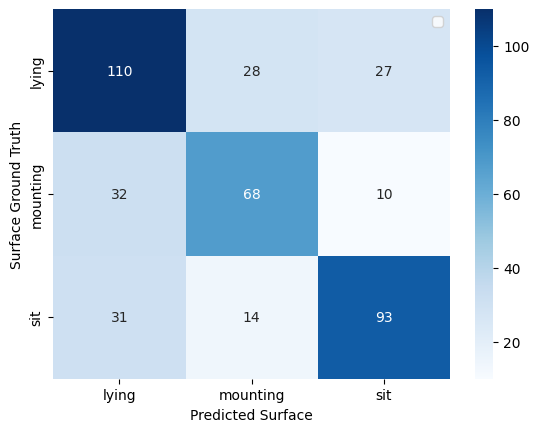

In [23]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()

show_confusion_matrix(df_cm)

## save model


In [24]:
PATH_SAVE = '/home/skpark/git/pose-detection-keypoints-estimation-yolov8/class_train/pose_classification.pt'
torch.save(model.state_dict(), PATH_SAVE)

## Load Inference Model

In [25]:
model_inference =  NeuralNet(
        X_train.shape[1],
        hidden_size,
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

<All keys matched successfully>

In [26]:
print(test_dataset.__len__)
feature, label = test_dataset.__getitem__(0)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'

    )

<bound method DataKeypointClassification.__len__ of <__main__.DataKeypointClassification object at 0x7efc5cf4e0d0>>
    prediction label : sit 
    ground thrut label : lying


In [27]:
encoder.classes_

array(['lying', 'mounting', 'sit'], dtype=object)